In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv, json, itertools
import pandas as pd
import scipy.optimize as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py

In [65]:
run_dir = "log_output/write_tests/"
log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = np.array(log_file['ts'].tolist())
log_file[:]


,L,steps,a,b,w,n_runs,ts
0,10,99,0.1,0.105,6.6,240,809882521066.01.0
1,10,99,0.1,0.105,6.6,240,809983961066.01.0
2,20,399,0.1,0.105,6.6,240,811624702066.01.0
3,20,399,0.1,0.105,6.6,240,811707302066.01.0


In [3]:
def output_reader(measure_list, fname):
    J_dist_list = [np.array([]) for step in range(len(measure_list))]
    h_dist_list = [np.array([]) for step in range(len(measure_list))] 

    #In1629_J_m3571

    with open(fname, 'r') as reader:
        next(reader)
        for line in reader:
            marker_end = line.find('[')
            inst_num = int(line[2:6])
            coupling_type = line[7:8]
            measure_ind = np.where(measure_list==int(line[10:marker_end]))[0][0]
            couplings = np.array(json.loads(line[marker_end:]))
            if coupling_type == 'h':
                if len(h_dist_list[measure_ind]) == 0:
                    h_dist_list[measure_ind] = couplings
                else:
                    h_dist_list[measure_ind] = np.concatenate((h_dist_list[measure_ind], couplings))
            elif coupling_type == 'J':
                if len(J_dist_list[measure_ind]) == 0:
                    J_dist_list[measure_ind] = couplings
                else:
                    J_dist_list[measure_ind] = np.concatenate((J_dist_list[measure_ind], couplings))
    
    return h_dist_list, J_dist_list

In [64]:
log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = np.array(log_file['ts'].tolist())
ts = str(ts_list[36])

with open(run_dir+"LIsing_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
        
with open(run_dir+"LIsing_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
measure_list = input_dict['measure_list']
h_dist_list, J_dist_list = output_reader(measure_list, run_dir+"LIsing_2D_output_"+ts+".txt")
print(input_dict)

{'L': 80, 'steps': 6380, 'measure_list': array([5760, 5867, 5956, 6030, 6092, 6143, 6186, 6222, 6252, 6277, 6297,
       6314, 6329, 6341, 6351, 6359, 6366, 6372, 6376, 6380]), 'a': 0.1, 'b': 0.105, 'w': 5.0, 'n_runs': 160}


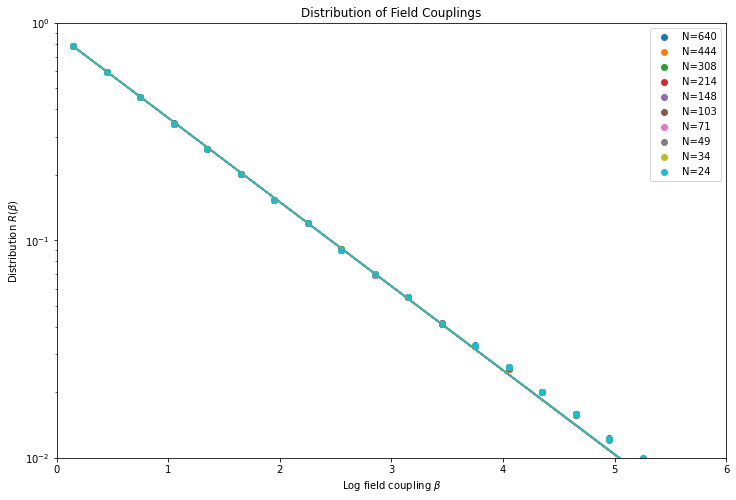

In [65]:
measure_list = input_dict['measure_list']
L = input_dict['L']
spins_left = L*L - measure_list
n_runs = input_dict['n_runs']
n_bins_h = 40
width_list = []
plt.figure(figsize=(12, 8))

for i,step in enumerate(spins_left[:-1]): 
    n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)
    y = n
    popt, pcov = curve_fit(exponential_dist_norm, x[1:30], y[1:30])
    if i%2==0: 
        plt.scatter(x, y, label="N="+str(step), marker='o')
        plt.plot(x, exponential_dist_norm(x, *popt))
        #print(popt)
    width_list.append(1/popt[0])

#plt.yscale('log')
#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

x_temp = np.linspace(0, 12)
#plt.plot(x_temp, np.exp(-x_temp), c='k')

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.xlim(0, 6)
plt.ylim(1e-2, 1)
plt.legend()

/home/guaravtenkila/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


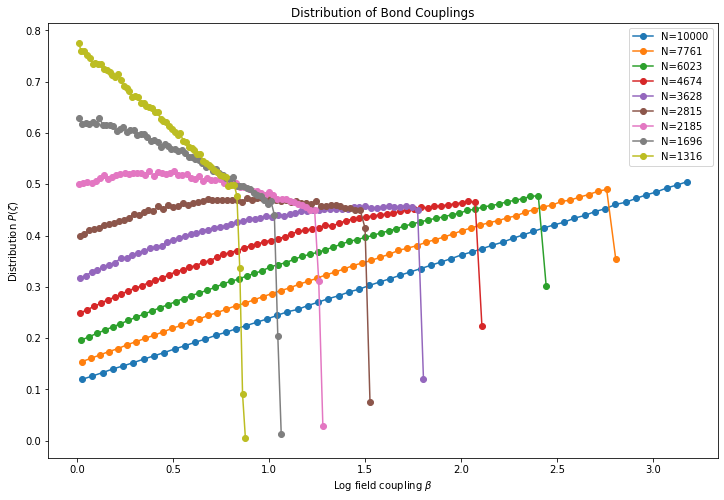

In [194]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_J = 60
#width_list = []
plt.figure(figsize=(12, 8))

for i,step in enumerate(spins_left[:-1]): 
    n,bins = np.histogram(J_dist_list[i], density=True, bins = n_bins_J)
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)/width_list[i]
    y = n
    if i<9: plt.plot(x, y, label="N="+str(step), marker='o')

    #popt, pcov = curve_fit(exponential_dist_norm, x[:20], y[:20])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    #width_list.append(1/popt[0])


#plt.xlim(0, 2)
#plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $P(\zeta)$")
plt.title("Distribution of Bond Couplings")

plt.legend()

[0.00184493 1.13197113]


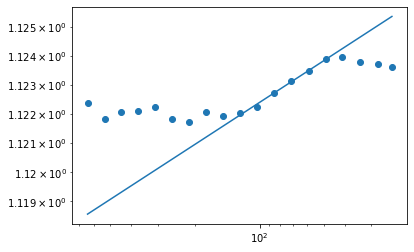

In [67]:
plt.scatter(spins_left[:-1], width_list)
x = spins_left[:-1]

popt, pcov = curve_fit(power_law_scale, x[-10:-5], width_list[-10:-5])
plt.plot(x, power_law_scale(x, *popt))
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
print(popt)
#plt.scatter([L*L], [1])

#Note: Improve fitting on the distribution, I think that's where your issue is coming from

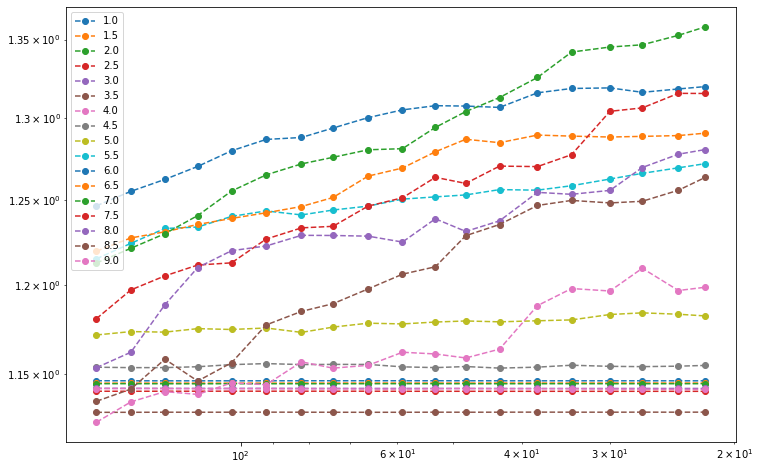

In [16]:
plt.figure(figsize=(12, 8))
scaling_index = []
param_list = []

for index, ts in enumerate(ts_list[:17]):
    with open(run_dir+"LIsing_2D_input_"+str(ts)+".pkl", "rb") as fp:   
        input_dict = pickle.load(fp)
        
    measure_list = input_dict['measure_list']
    
    h_dist_list, J_dist_list = output_reader(measure_list, run_dir+"LIsing_2D_output_"+str(ts)+".txt")
    
    L = input_dict['L']
    spins_left = L*L - measure_list
    n_runs = input_dict['n_runs']
    n_bins_h = 60
    width_list = []
    for i,step in enumerate(spins_left[:-1]): 
        n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
        width = bins[1]-bins[0]
        x = (bins[1:]-width/2)
        y = n
        popt, pcov = curve_fit(exponential_dist_norm, x[1:30], y[1:30])
        width_list.append(1/popt[0])
    
    plt.plot(spins_left[:-1], width_list, label=input_dict['w'], linestyle='--', marker='o')
    x = spins_left[:-1]
    popt, pcov = curve_fit(power_law_scale, x[-6:], width_list[-6:])
    param_list.append(input_dict['w'])
    scaling_index.append(popt[0])
    
plt.legend()
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')

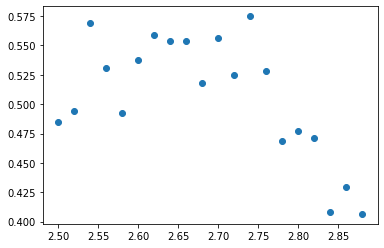

In [134]:
plt.scatter(param_list, scaling_index)

In [5]:
L = 40
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()

w_vals = fixed_length_slice['w'].tolist()
largest_clust_size = []
var_lcs = [] 
c_list = []
c_dict = {40: 'magenta', 60:'red', 80:'blue', 100:'green'}

for index, ts in enumerate(ts_list):

    with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []
    
    largest_clust_list  = []
    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp
        #largest_clust_list+=[max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_list_temp]

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_list = np.array(largest_clust_list)
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    var_lcs.append(largest_clust_list.std()/L**2)
    c_list.append(c_dict[L])

Text(0.5, 1.0, 'Largest Spin Cluster and Variance in Size')

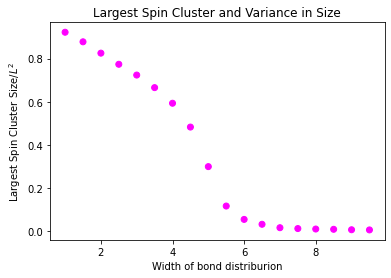

In [6]:
#plt.errorbar(w_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='')
plt.scatter(w_vals, largest_clust_size, c=c_list)
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster and Variance in Size")


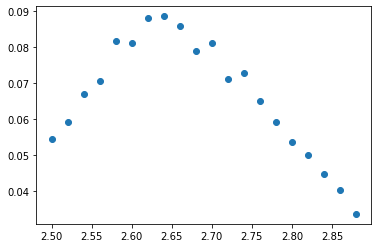

In [29]:
sorted_y = np.array([x for _,x in sorted(zip(w_vals,var_lcs))])
sorted_x = np.array(sorted(w_vals))
plt.scatter(sorted_x, sorted_y)


In [8]:
L_list = [40, 60, 80]
c_dict = {40: 'magenta', 60:'red', 80:'blue', 100:'green'}



w_vals_comp = []
lcs_comp = []

for L in L_list:
    log_file = pd.read_csv(run_dir+"log_file.csv")
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    largest_clust_size = []
    var_lcs = [] 
    c_list = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        largest_clust_size.append(largest_clust_list.mean()/L**2)
        var_lcs.append(largest_clust_list.std()/L**2)
        #c_list.append(c_dict[L])
    
    w_vals_comp.append(w_vals)
    lcs_comp.append(largest_clust_size)
    

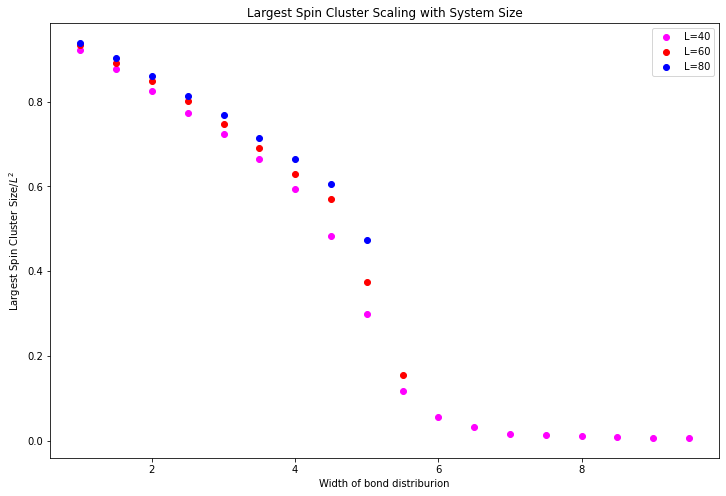

In [9]:
plt.figure(figsize=(12, 8))

for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], lcs_comp[i], c=c_dict[L], label='L='+str(L))
    
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster Scaling with System Size")
plt.legend()

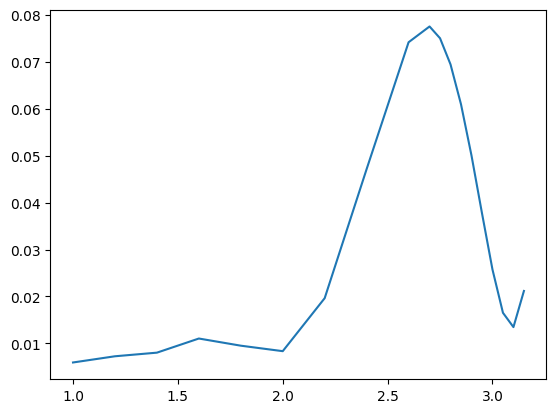

In [21]:
sorted_y = np.array([x for _,x in sorted(zip(w_vals,var_lcs))])
sorted_x = np.array(sorted(w_vals))

poly_degree = 7

poly = PolynomialFeatures(degree = poly_degree)
poly_features = poly.fit_transform(sorted_x.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, sorted_y)
y_predicted = poly_reg_model.predict(poly_features)

plt.plot(sorted_x, y_predicted)

[0.58600978 1.84757256]


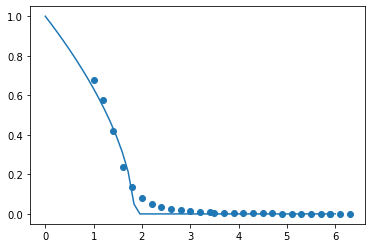

In [37]:
x = np.linspace(0, 6)

def order_param_func(x, scaling, crit_point):
    return np.piecewise(x, [x < crit_point, x >= crit_point], [lambda x: (1-x/crit_point)**scaling, 0])


popt, pcov = curve_fit(order_param_func, w_vals, largest_clust_size)

plt.plot(x, order_param_func(x, *popt))
plt.scatter(w_vals, largest_clust_size)
print(popt)

In [5]:
def check_percolation(clust_dict, L, width):
    end_point = int(L/2)
    for y1 in range(L):
        for y1_width in range(-width, width+1):
            for y2 in range(L):
                for y2_width in range(-width, width+1):
                    start_ind = index_map(y1_width%L, y1, L)
                    end_index = index_map((end_point+y2_width)%L, y2, L)
                    if (clust_dict[start_ind] == clust_dict[end_index]): 
                        return True
    return False
        

Text(0.5, 1.0, 'Percolation Transition')

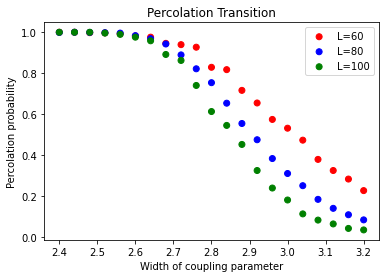

In [10]:
for L in [60, 80, 100]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()

    p_perc_clust = []
    c_list = []
    #color_dict = {50:'blue', 60:'red', 40:'green'}

    for index, ts in enumerate(ts_list):

        with open(run_dir+"Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        perc_cluster = []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        perc_prob_temp = np.array([check_percolation(clust, L, 2) for clust in clust_dict_list])

        p_perc_clust.append(perc_prob_temp.mean())
        c_list.append(c_dict[L])
   
    plt.scatter(w_vals, p_perc_clust, c=c_list, label="L="+str(L))
    

plt.legend()
plt.ylabel("Percolation probability")
plt.xlabel("Width of coupling parameter")
plt.title("Percolation Transition")

In [48]:
def extract_cluster_sizes(reverse_dict_list):
    clust_size_list = []
    for i, reverse_dict in enumerate(reverse_dict_list):
        for cluster in reverse_dict.values():
            if cluster is None: continue
            clust_size_list.append(len(cluster))
    return np.array(clust_size_list)

def get_distribution_curvature(hist, bin_edges):
    width = bin_edges[1]-bin_edges[0]
    x = bin_edges[1:]-width/2   #Realigning x-axis
    
    cdf = np.cumsum(hist)        #Cumulative distribution function for pdf given by histogram
    smooth = gaussian_filter1d(cdf, 1)       #Gaussian smoothing of cdf function in order to take derivative
    second_der = np.gradient(np.gradient(smooth))
    a = np.diff(np.sign(np.diff(second_der))).nonzero()[0] + 1    #Checking where there is a jump in cdf
    
    infl_size = second_der[a[-2]]-second_der[a[-1]]            #Size of the last jump (empirically determined)
    
    return infl_size

In [8]:
L_list = [100]#, 70, 85, 50]
clust_size_list_comp = []
clust_size_list_bdry_comp = []
w_vals_comp = []
run_dir = "crit_test_runs/"
log_file = pd.read_csv(run_dir+"log_file.csv")[5:]

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    clust_size_list = []
    clust_dict_list_bdry = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
        
        clust_sizes = extract_cluster_sizes(reverse_dict_list)
        #List of sizes of all clusters normalized to system size       
        clust_size_list.append(clust_sizes[clust_sizes!=1]/L**2)

    w_vals_comp.append(w_vals)
    clust_size_list_comp.append(clust_size_list)

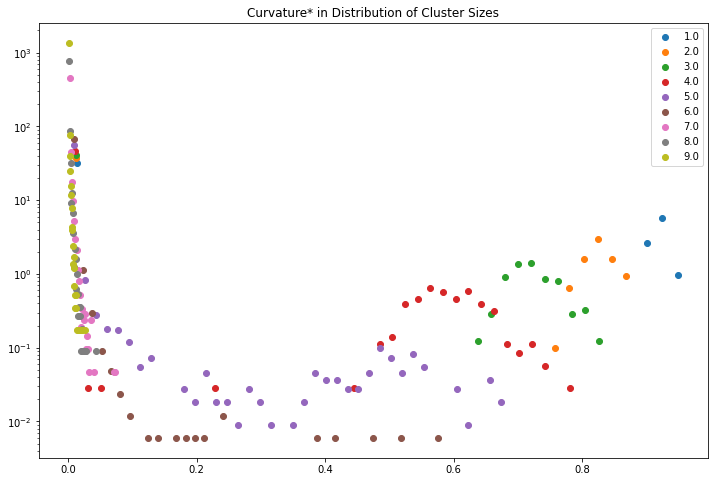

In [71]:
from scipy.ndimage import gaussian_filter1d
import scipy.signal as sg

fig, ax0 = plt.subplots(figsize=(12, 8))

c_dict = {40:'red', 70:'blue', 60:'green', 80:'cyan', 30:'orange', 100:'magenta', 85:'orange'}
cmap_type = {40:'Greens', 60:'Blues', 80:'Reds', 100:'Greys'}
for ind, L in enumerate(L_list[1:2]):
    curve_check = []
    mean_clust_size = []
    cdf_max = []
    for index, w in enumerate(w_vals_comp[ind]):
        if not index%2==0: continue
        #if not index==0: continue    
        cmap_L = cm.get_cmap(cmap_type[L])
        norm = plt.Normalize(2, 3)
        hist, bin_edges = np.histogram(clust_size_list_comp[ind][index], density=True, bins=40)
        width = bin_edges[1]-bin_edges[0]
        x = bin_edges[1:]-width/2
        ax0.scatter(x, hist, label=str(w))
        
        infl_size = get_distribution_curvature(hist, bin_edges)
        curve_check.append(infl_size)

        #Attempt at doing statistics on cluster sizes
        """
        cs_list = clust_size_list_comp[ind][index]
        cs_list = cs_list[cs_list>(0.8*L/(L*L))]
        mean_clust_size.append(np.median(cs_list))
        """
        
        #Attempt at checking concavity of the distribution to identify transition
        """
        raw = np.log(hist)[5:]
        ax0.plot(raw, color=cmap_L(norm(w)))
        smooth = gaussian_filter1d(raw, 1)
        ax0.plot(smooth, color=cmap_L(norm(w)), linestyle='--')
        smooth_d1 = np.gradient(smooth[smooth>-4])
        curve_check.append(np.sum(smooth_d1))
        """
        
    
    #ax0.plot(w_vals_comp[ind], mean_clust_size, c=c_dict[L], marker='o')
    #ax0.scatter(w_vals_comp[ind], cdf_max, c=c_dict[L], marker='o')
    #ax0.scatter(w_vals_comp[ind], curve_check, c=c_dict[L], marker='o', label="L="+str(L))
    #fig, ax = plt.subplots(figsize=(6, 1))
    #fig.subplots_adjust(bottom=0.5)
    #cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap_L,
    #                            norm=norm,
    #                            orientation='horizontal')
    
ax0.set_title("Curvature* in Distribution of Cluster Sizes")
ax0.axhline(y=0)
#ax0.xscale('log')
ax0.set_yscale('log')
plt.legend()

In [49]:
L_list = [40, 60, 80]
clust_size_list_comp = []
clust_size_list_bdry_comp = []
w_vals_comp = []
run_dir = "run_set_1/"
log_file = pd.read_csv(run_dir+"log_file.csv")

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    clust_size_list = []
    clust_dict_list_bdry = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
        
        clust_sizes = extract_cluster_sizes(reverse_dict_list)
        #List of sizes of all clusters normalized to system size       
        clust_size_list.append(clust_sizes[clust_sizes!=1]/L**2)

    w_vals_comp.append(w_vals)
    clust_size_list_comp.append(clust_size_list)

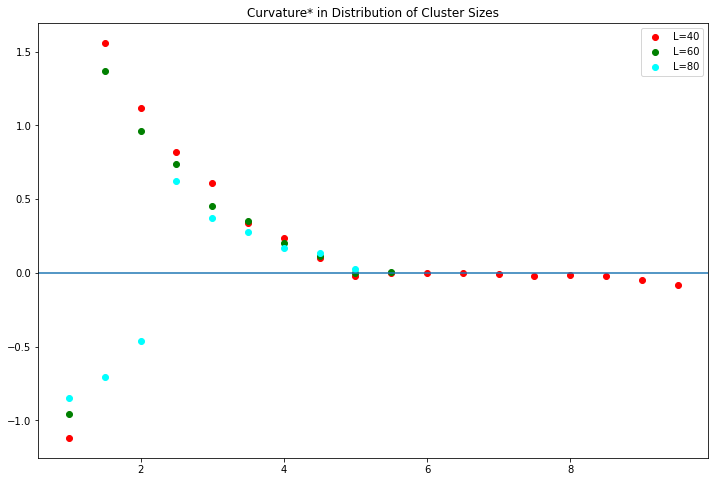

In [51]:
from scipy.ndimage import gaussian_filter1d
import scipy.signal as sg

fig, ax0 = plt.subplots(figsize=(12, 8))

c_dict = {40:'red', 70:'blue', 60:'green', 80:'cyan', 30:'orange', 100:'magenta', 85:'orange'}
cmap_type = {40:'Greens', 60:'Blues', 80:'Reds', 100:'Greys'}
for ind, L in enumerate(L_list):
    curve_check = []
    mean_clust_size = []
    cdf_max = []
    for index, w in enumerate(w_vals_comp[ind]):
        #if not index%3==0: continue
        #if not index==0: continue    
        cmap_L = cm.get_cmap(cmap_type[L])
        norm = plt.Normalize(2, 3)
        hist, bin_edges = np.histogram(clust_size_list_comp[ind][index], density=True, bins=40)
        width = bin_edges[1]-bin_edges[0]
        x = bin_edges[1:]-width/2
        #ax0.scatter(x, hist, label=str(w))
        
        infl_size = get_distribution_curvature(hist, bin_edges)
        curve_check.append(infl_size)

        #Attempt at doing statistics on cluster sizes
        """
        cs_list = clust_size_list_comp[ind][index]
        cs_list = cs_list[cs_list>(0.8*L/(L*L))]
        mean_clust_size.append(np.median(cs_list))
        """
        
        #Attempt at checking concavity of the distribution to identify transition
        """
        raw = np.log(hist)[5:]
        ax0.plot(raw, color=cmap_L(norm(w)))
        smooth = gaussian_filter1d(raw, 1)
        ax0.plot(smooth, color=cmap_L(norm(w)), linestyle='--')
        smooth_d1 = np.gradient(smooth[smooth>-4])
        curve_check.append(np.sum(smooth_d1))
        """
        
    
    #ax0.plot(w_vals_comp[ind], mean_clust_size, c=c_dict[L], marker='o')
    #ax0.scatter(w_vals_comp[ind], cdf_max, c=c_dict[L], marker='o')
    ax0.scatter(w_vals_comp[ind], curve_check, c=c_dict[L], marker='o', label="L="+str(L))
    #fig, ax = plt.subplots(figsize=(6, 1))
    #fig.subplots_adjust(bottom=0.5)
    #cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap_L,
    #                            norm=norm,
    #                            orientation='horizontal')
    
ax0.set_title("Curvature* in Distribution of Cluster Sizes")
ax0.axhline(y=0)
#ax0.xscale('log')
#ax0.set_yscale('log')
plt.legend()

In [200]:
L_list = [60, 80, 100]
c_dict = {60:'red', 80:'blue', 100:'green'}


w_vals_comp = []
moment_array_comp = []

for L in L_list:
    log_file = pd.read_csv(run_dir+"log_file.csv")
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    mean_moment_list = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        moment_list_comp = []

        for core_pair in clust_list_final:
            moment_list_temp = core_pair[2]
            moment_list_comp+=moment_list_temp
        
        mean_moment_list.append(np.array(moment_list_comp).mean(axis=0))
    
    w_vals_comp.append(w_vals)
    moment_array_comp.append(mean_moment_list)

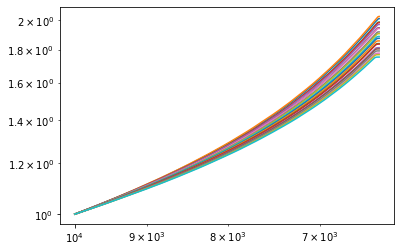

In [204]:
for ind, L in enumerate(L_list[2:]):
    for index, w in enumerate(w_vals_comp[ind]):
        y_data = moment_array_comp[ind][index]
        x_axis = L*L - np.arange(len(y_data))
        plt.plot(x_axis, y_data, label=str(w))

#plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_xaxis()

In [36]:
run_dir = "log_output/write_tests/"
log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = np.array(log_file['ts'].tolist())
log_file[:]


,L,steps,a,b,w,n_runs,ts
0,20,399,0.1,0.105,6.6,1440,722725232066.01.0
1,16,255,0.1,0.105,6.6,1440,724456161666.01.0


In [8]:
def output_reader(measure_list, fname):
    J_dist_dict = [{} for _ in range(len(measure_list))]
    h_dist_dict = [{} for _ in range(len(measure_list))]

    #In1629_J_m3571
    with open(fname, 'r') as reader:
        next(reader)
        for line in reader:
            marker_end = line.find('[')
            if line[6]=='_': inst_end = 6
            elif line[7]=='_': inst_end = 7
            else: print("Read error")
            inst_num = int(line[2:inst_end])
            coupling_type = line[inst_end+1:inst_end+2]
            if coupling_type=='r':continue
            measure_ind = np.where(measure_list==1+int(line[inst_end+4:marker_end]))[0][0]
            try:
                couplings = np.array(json.loads(line[marker_end:]))
            except:
                print("Corrupted file")
            if coupling_type == 'h':
                h_dist_dict[measure_ind][inst_num] = couplings
            elif coupling_type == 'J':
                J_dist_dict[measure_ind][inst_num] = couplings
    
    return [h_dist_dict, J_dist_dict]

def unpack_dictionaries(file_out, measure_list):
    h_dist_dict, J_dist_dict = file_out
    h_dist_list, J_dist_list = [], []
    
    for i in range(len(measure_list)):
        h_dist_list.append(np.concatenate(tuple(h_dist_dict[i].values())))
        J_dist_list.append(np.concatenate(tuple(J_dist_dict[i].values())))
        
    return h_dist_list, J_dist_list

In [105]:
log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = np.array(log_file['ts'].tolist())
ts = str(ts_list[-1])

with open(run_dir+"LIsing_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
        
with open(run_dir+"LIsing_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
measure_list = input_dict['measure_list']


In [115]:
with open(run_dir+"LIsing_2D_distdata_"+ts+".pkl", "rb") as fp:   
    zeta_list_final = pickle.load(fp)
    
clust_list_comp = [[] for _ in range(len(measure_list))]
for core_pair in zeta_list_final:
        clust_list_temp = core_pair[0]
        for ind, item in enumerate(clust_list_temp):
            clust_list_comp[ind]+=item

In [117]:
len(clust_list_comp[0])

240

In [43]:
zeta_dist_list_test = [[] for _ in range(len(measure_list)-3)]

for ind in range(len(measure_list)-3):
    for zeta in zeta_list_comp:
        zeta_dist_list_test[ind]+=zeta[ind].data

In [52]:
clust_list_dict = {}
clust_list_dict[1]=[1]

In [119]:
a = np.random.random(20)
bdry_list = np.zeros(20, dtype=bool)
bdry_list[5:] = True

len(a[bdry_list])

15